In [1]:
from functools import reduce

from cycler import cycler
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from numbers import Number
import numpy as np
import pandas as pd
#from scipy import stats as sstats
import wmfdata as wmf
from wmfdata.utils import pct_str, sig_figs
from wmfdata.charting import pct_fmt, M_fmt, comma_fmt

import gspread
from google.oauth2.service_account import Credentials

In [2]:
%matplotlib inline
wmf.charting.set_mpl_style()

In [3]:
FILE = "metrics/metrics.tsv"
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

FILE_D =  "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(FILE_D, sep="\t", parse_dates=["month"]).set_index("month")

graph_end = metrics.index[-1]
graph_start = graph_end - relativedelta(months = 47)
prior_month = graph_end- relativedelta(months = 1)

# Data transformation

In [4]:
# Transform content flows into content stocks
def stock_to_flow(arr):
    return arr[-1] - arr[0]

flow_cols = [
    "net_new_content_pages", 
    "net_new_Wikipedia_articles", 
    "net_new_Commons_content_pages", 
    "net_new_Wikidata_entities"
]
stock_cols = [
    "content_pages", 
    "Wikipedia_articles", 
    "Commons_content_pages",
    "Wikidata_entities"
]

name_map = {flow_cols[i]: stock_cols[i] for i in range(len(stock_cols))}

stock_metrics = metrics[flow_cols].cumsum().rename(name_map, axis=1)

metrics = pd.concat([metrics, stock_metrics], axis=1)

# Show results
metrics.tail()

,active_editors,anonymous_edits,global_south_active_editors,global_south_edits,global_south_new_editor_retention,global_south_nonbot_edits,mobile-heavy_wiki_active_editors,mobile-heavy_wiki_edits,mobile-heavy_wiki_new_editor_retention,mobile-heavy_wiki_nonbot_edits,...,other_nonbot_edits,returning_active_editors,revert_rate,total_edits,uploads,wikidata_edits,content_pages,Wikipedia_articles,Commons_content_pages,Wikidata_entities
month,,,,,,,,,,,,,,,,,,,,,
2021-11-01,89995.0,2018200.0,23066.0,3303526.0,NaN,2550849.0,5107.0,973932.0,0.056051,629947.0,...,5973130.0,73409.0,0.054219,39436215.0,586487.0,16358067.0,292737457.0,59492498.0,80005571.0,97772504.0
2021-12-01,89356.0,1995954.0,23172.0,3312507.0,NaN,2672058.0,5315.0,1060115.0,0.048249,659813.0,...,8267140.0,73315.0,0.053034,41299016.0,746046.0,16768078.0,294391137.0,59773599.0,80701637.0,98218598.0
2022-01-01,94400.0,2196791.0,24440.0,4380346.0,NaN,2692378.0,5588.0,2068915.0,0.049787,721691.0,...,11540342.0,76652.0,0.054356,46267521.0,781837.0,17365714.0,296061899.0,60105188.0,81405224.0,98596714.0
2022-02-01,88282.0,1958744.0,22935.0,3737443.0,NaN,2381297.0,5256.0,1374497.0,0.048724,572935.0,...,10177703.0,72084.0,0.059112,38580288.0,612714.0,13450324.0,297310580.0,60324013.0,81974348.0,98820743.0
2022-03-01,91776.0,2094120.0,23773.0,3205072.0,NaN,2426786.0,5334.0,993853.0,0.054394,582447.0,...,10696650.0,74000.0,0.047048,52020405.0,717167.0,22334725.0,298905504.0,60532323.0,82652424.0,99177413.0


In [5]:
metrics.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 256 entries, 2001-01-01 to 2022-03-01
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   active_editors                          256 non-null    float64
 1   anonymous_edits                         45 non-null     float64
 2   global_south_active_editors             43 non-null     float64
 3   global_south_edits                      43 non-null     float64
 4   global_south_new_editor_retention       34 non-null     float64
 5   global_south_nonbot_edits               43 non-null     float64
 6   mobile-heavy_wiki_active_editors        245 non-null    float64
 7   mobile-heavy_wiki_edits                 245 non-null    float64
 8   mobile-heavy_wiki_new_editor_retention  231 non-null    float64
 9   mobile-heavy_wiki_nonbot_edits          245 non-null    float64
 10  mobile_edits                            256

In [6]:
diversity_metrics.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2018-01-01 to 2022-03-01
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   global_north_active_editors        31 non-null     float64
 1   global_north_edits                 31 non-null     float64
 2   global_north_net_new_content       31 non-null     float64
 3   global_north_new_editor_retention  20 non-null     float64
 4   global_north_nonbot_edits          31 non-null     float64
 5   global_north_wikidata_entities     31 non-null     float64
 6   global_south_active_editors        43 non-null     float64
 7   global_south_edits                 43 non-null     float64
 8   global_south_net_new_content       31 non-null     float64
 9   global_south_new_editor_retention  34 non-null     float64
 10  global_south_nonbot_edits          43 non-null     float64
 11  global_south_wikidata_entities     31 no

In [7]:
metrics_all = pd.concat([metrics, diversity_metrics], axis=1)
metrics_all  = metrics_all.loc[:,~metrics_all.columns.duplicated()]

In [8]:
metrics_all

,active_editors,anonymous_edits,global_south_active_editors,global_south_edits,global_south_new_editor_retention,global_south_nonbot_edits,mobile-heavy_wiki_active_editors,mobile-heavy_wiki_edits,mobile-heavy_wiki_new_editor_retention,mobile-heavy_wiki_nonbot_edits,...,Commons_content_pages,Wikidata_entities,global_north_active_editors,global_north_edits,global_north_net_new_content,global_north_new_editor_retention,global_north_nonbot_edits,global_north_wikidata_entities,global_south_net_new_content,global_south_wikidata_entities
month,,,,,,,,,,,,,,,,,,,,,
2001-01-01,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-02-01,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-03-01,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-01,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-01,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,89995.0,2018200.0,23066.0,3303526.0,NaN,2550849.0,5107.0,973932.0,0.056051,629947.0,...,80005571.0,97772504.0,71341.0,21041572.0,1070166.0,NaN,11554411.0,375992.0,289701.0,37997.0
2021-12-01,89356.0,1995954.0,23172.0,3312507.0,NaN,2672058.0,5315.0,1060115.0,0.048249,659813.0,...,80701637.0,98218598.0,71335.0,21407369.0,1161660.0,NaN,11535733.0,387429.0,275998.0,23762.0
2022-01-01,94400.0,2196791.0,24440.0,4380346.0,NaN,2692378.0,5588.0,2068915.0,0.049787,721691.0,...,81405224.0,98596714.0,76266.0,21999821.0,1193327.0,NaN,12632692.0,299410.0,258871.0,62603.0


# Report

In [9]:
report_order = [
     #Editors
    'active_editors',
        'new_active_editors',
        'returning_active_editors',
    'new_editor_retention',
    # Content
    'content_pages', 
        'Wikipedia_articles',
        'Commons_content_pages', 
        'Wikidata_entities',
    'net_new_content_pages',
        'net_new_Wikipedia_articles',
        'net_new_Commons_content_pages',
        'net_new_Wikidata_entities',
    'revert_rate',
    'total_edits',
        'mobile_edits',
        'wikidata_edits',
        'uploads',
        'other_nonbot_edits',
        'anonymous_edits',
        'non_anonymous_edits',
    #Diversity Content
    'global_north_net_new_content',
    'global_south_net_new_content',
    'global_north_edits',
    'global_south_edits',
    #Diversity Editors
    'global_north_active_editors',
    'global_south_active_editors',
    #'global_north_new_editor_retention',
    #'global_south_new_editor_retention'

]

In [10]:
def fmt_num(x):
    if isinstance(x, Number) and not pd.isnull(x):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct_str(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def calc_rpt(ser):   
    cur = ser[-1]
    
    try:
        yr_prev = ser[-13]
        yoy_change = (cur / yr_prev) - 1
    except IndexError:
        yoy_change = None
        
    try:
        cagr = (ser[-1] / ser[-48])**(1/4) - 1
    except IndexError:
        cagr = None
        
    
    res = [cur, yoy_change, cagr]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["value", "yoy_change", "4_yr_cagr"]
    )

def calc_prev_month_rpt(ser):   
    pm_cur = ser[-2]
    
    try:
        pm_yr_prev = ser[-14]
        pm_yoy_change = (pm_cur / pm_yr_prev) - 1
    except IndexError:
        pm_yoy_change = None
        
    try:
        pm_cagr = (ser[-2] / ser[-49])**(1/4) - 1
    except IndexError:
        pm_cagr = None
        
    
    pm_res = [pm_cur, pm_yoy_change, pm_cagr]
    return pd.Series(
        [fmt_num(n) for n in pm_res],
        index=["previous_M_value", "PM_yoy_change", "PM4_yr_cagr"]
    )

In [11]:
print("Monthly report")
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(report_order)
    .fillna("—")
)

Monthly report


,value,yoy_change,4_yr_cagr
active_editors,"91,800",-8.5%,2.4%
new_active_editors,"17,800",-14.0%,2.8%
returning_active_editors,"74,000",-7.1%,2.4%
new_editor_retention,7.8%,4.8%,3.8%
content_pages,"299,000,000",8.3%,13.1%
Wikipedia_articles,"60,500,000",5.7%,6.0%
Commons_content_pages,"82,700,000",15.3%,15.4%
Wikidata_entities,"99,200,000",4.9%,20.6%
net_new_content_pages,"1,590,000",-49.3%,-7.2%
net_new_Wikipedia_articles,"208,000",-37.3%,4.8%


In [12]:
print("Previous month's report")
(
    metrics_all
    .apply(calc_prev_month_rpt)
    .transpose()
    .reindex(report_order)
    .fillna("—")
)

Previous month's report


,previous_M_value,PM_yoy_change,PM4_yr_cagr
active_editors,"88,300",-6.2%,0.7%
new_active_editors,"16,200",-13.5%,-1.8%
returning_active_editors,"72,100",-4.4%,1.3%
new_editor_retention,6.3%,-2.8%,-5.0%
content_pages,"297,000,000",8.9%,13.3%
Wikipedia_articles,"60,300,000",5.9%,6.0%
Commons_content_pages,"82,000,000",17.5%,15.6%
Wikidata_entities,"98,800,000",5.1%,21.2%
net_new_content_pages,"1,250,000",-43.0%,-11.6%
net_new_Wikipedia_articles,"219,000",-23.2%,1.9%


# Graphs

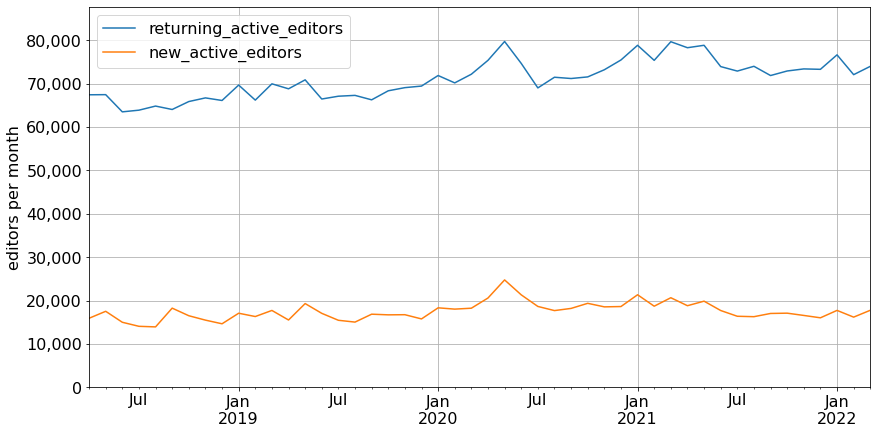

In [13]:
ax = metrics[["returning_active_editors", "new_active_editors"]][graph_start:graph_end].plot()
plt.gca().yaxis.set_major_formatter(comma_fmt)
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("editors per month");

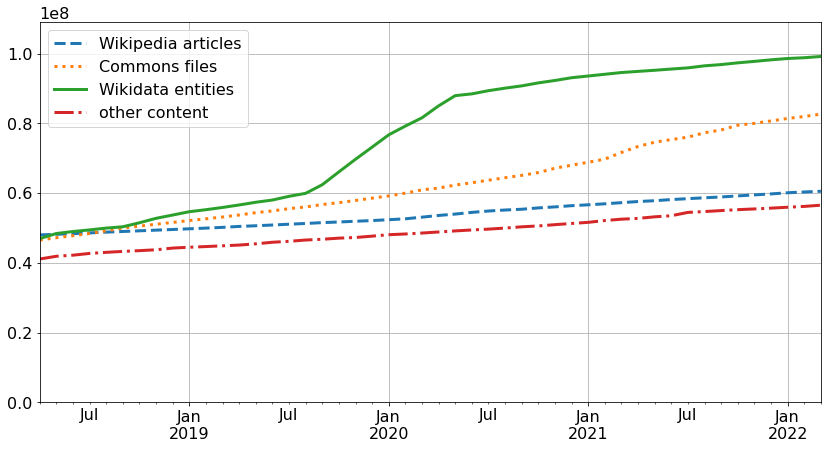

In [14]:
custom_cyc = cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['-', '--', ':', '-.'])
content_types = metrics[["Wikipedia_articles", "Commons_content_pages", "Wikidata_entities"]]
content_ser = [tup[1] for tup in content_types.iteritems()]

other_content = reduce(lambda x, y: x - y, content_ser, metrics["content_pages"]).rename("other_content")
content = pd.concat(
    [content_types, other_content], 
    axis=1
).rename(
    columns=lambda name: name.replace("_", " ")
).rename(
    columns={"Commons content pages": "Commons files"}
)

ax.set_prop_cycle(custom_cyc)
ax = content[graph_start:graph_end].plot(style=['--', ':', '-', '-.'], linewidth=3)

#ax.yaxis.set_major_formatter(M_fmt)
#--removed "ax.yaxis.set_major_formatter(M_fmt)" as a workaround to the error "M_str() takes 1 positional argument but 2 were given" that we encountered while running this notebok
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("");

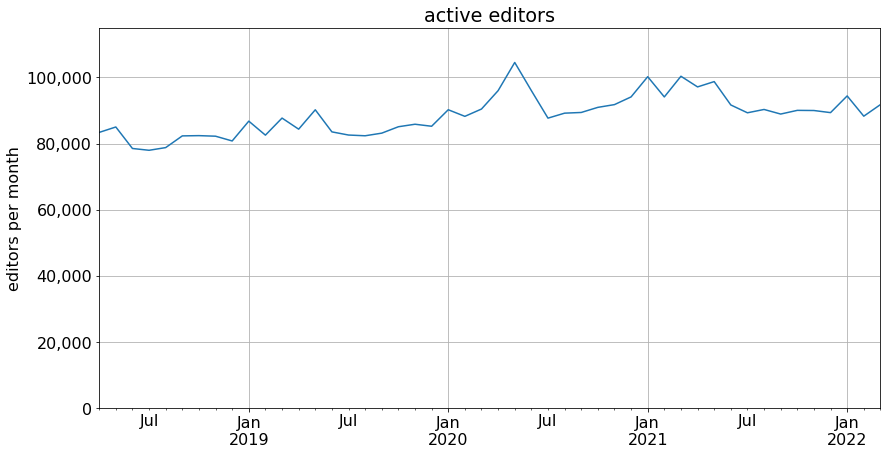

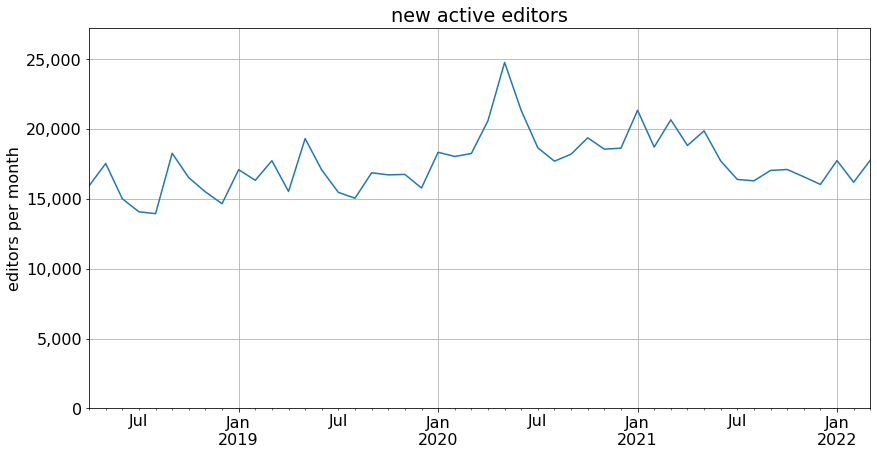

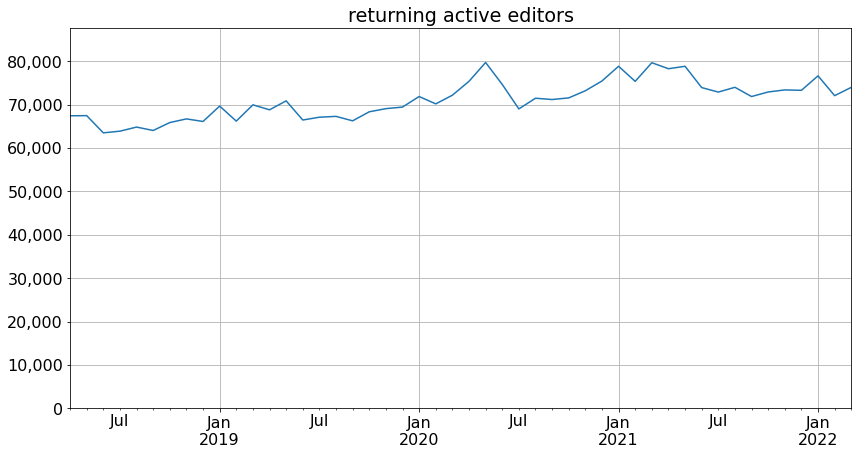

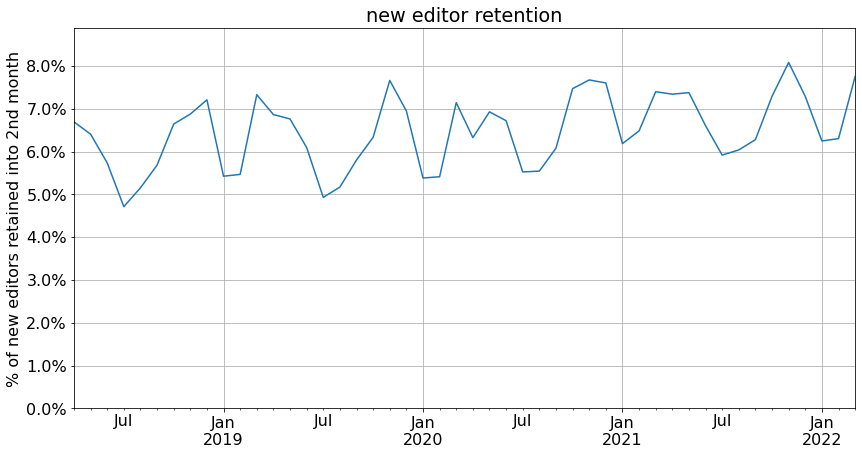

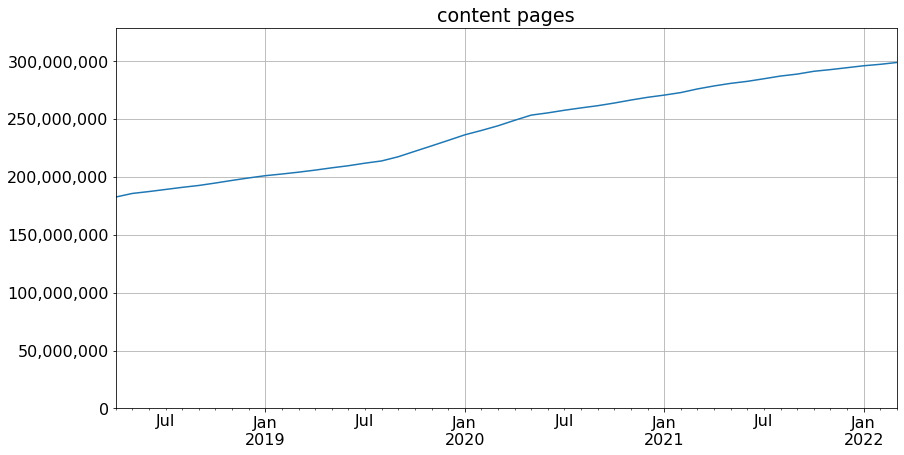

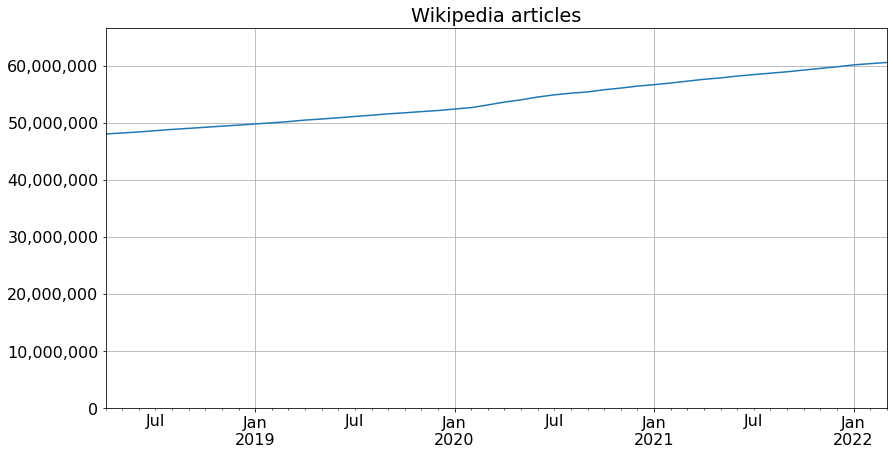

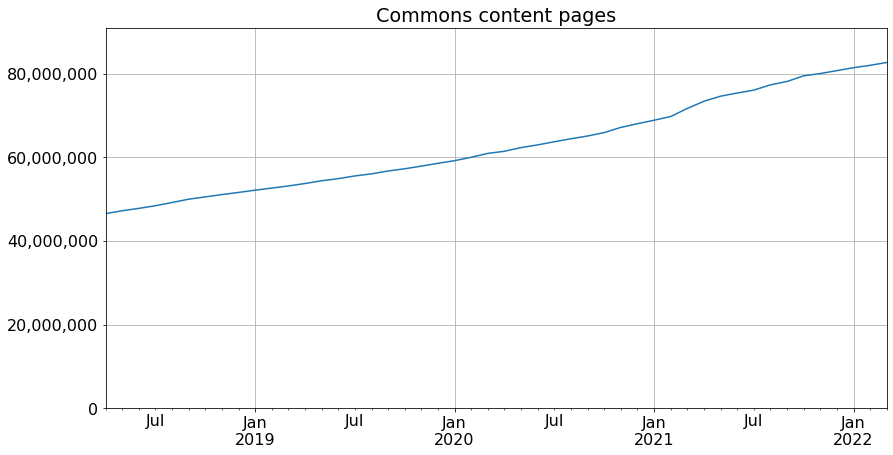

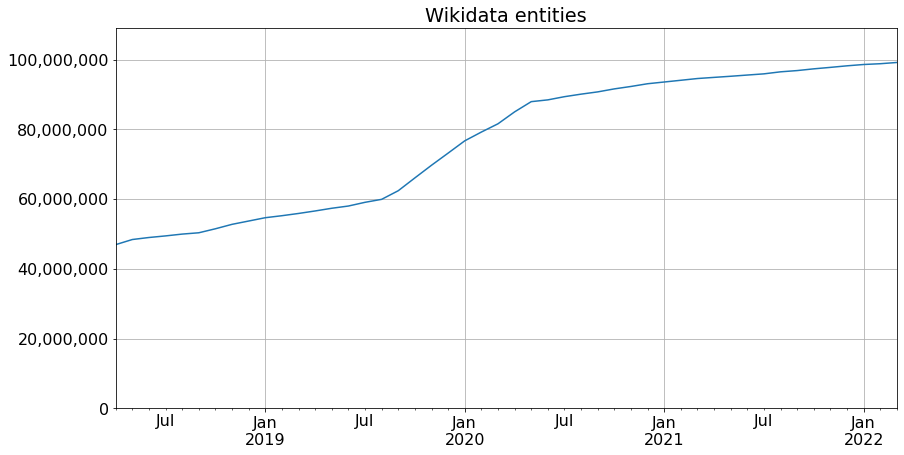

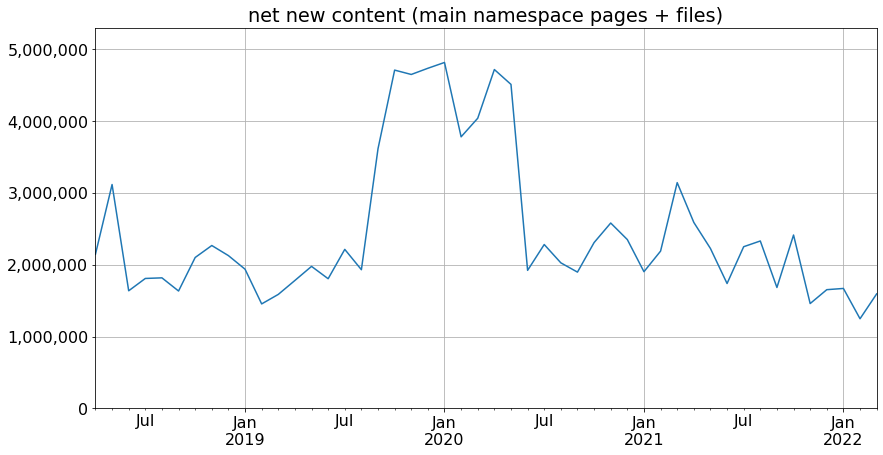

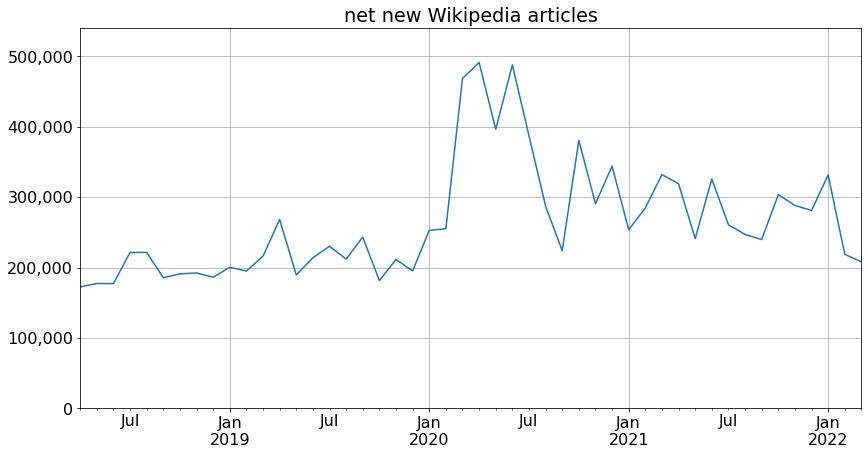

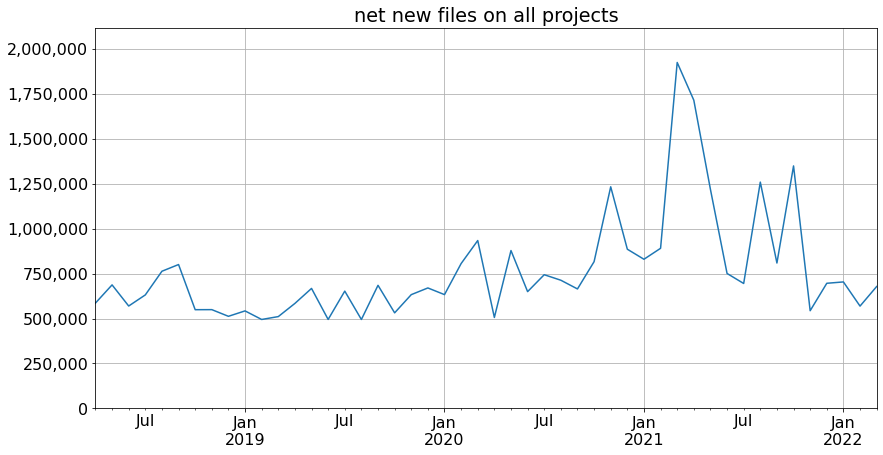

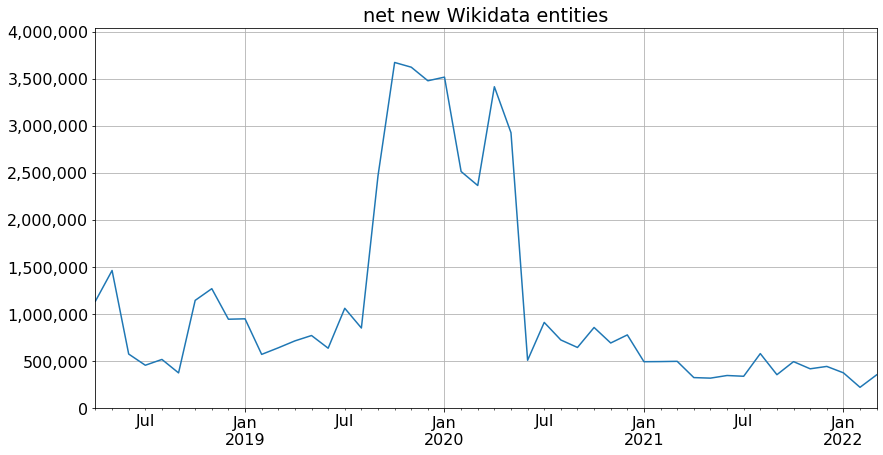

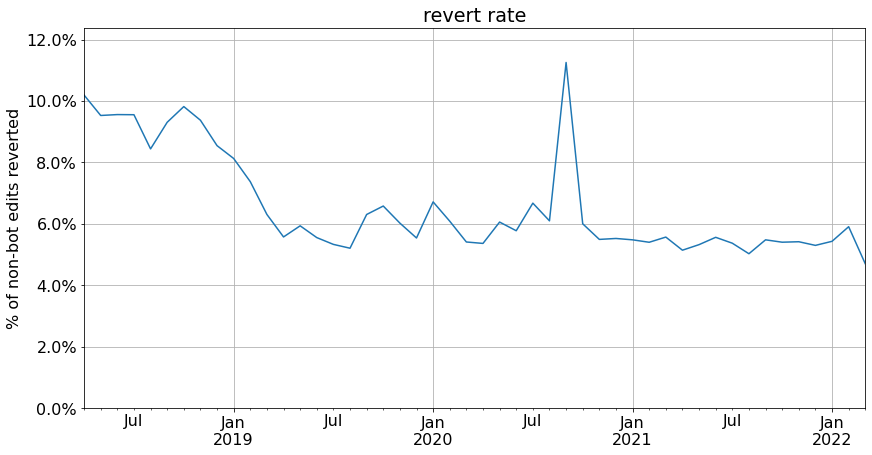

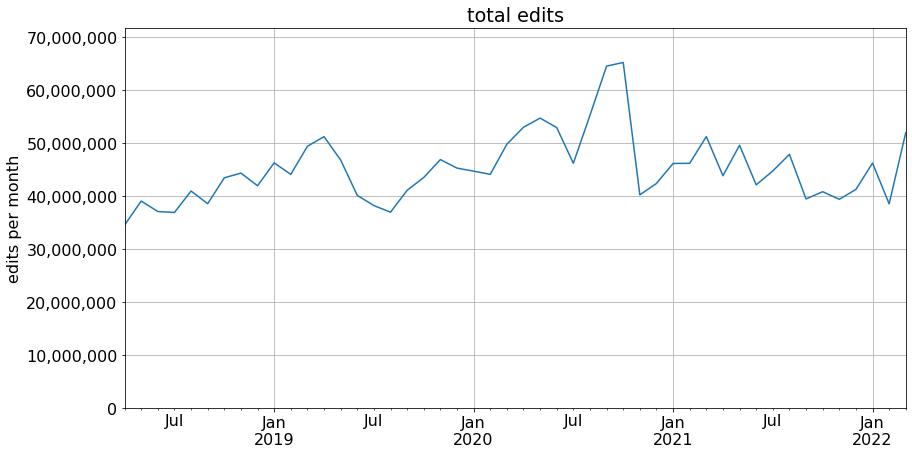

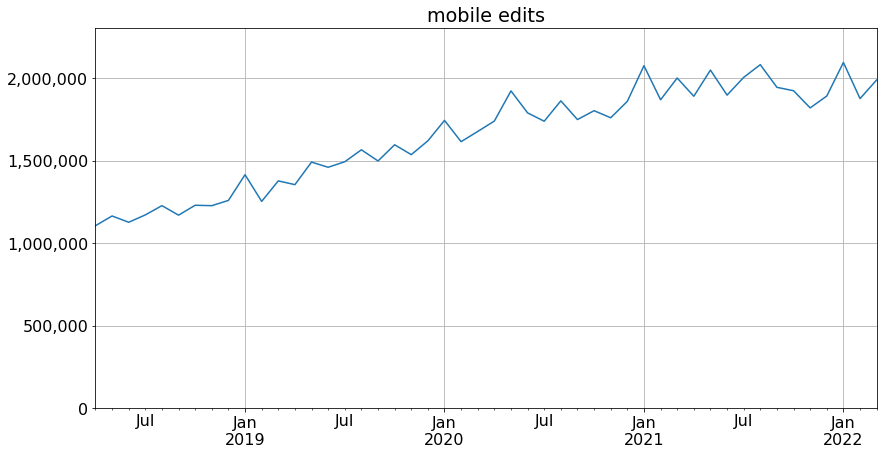

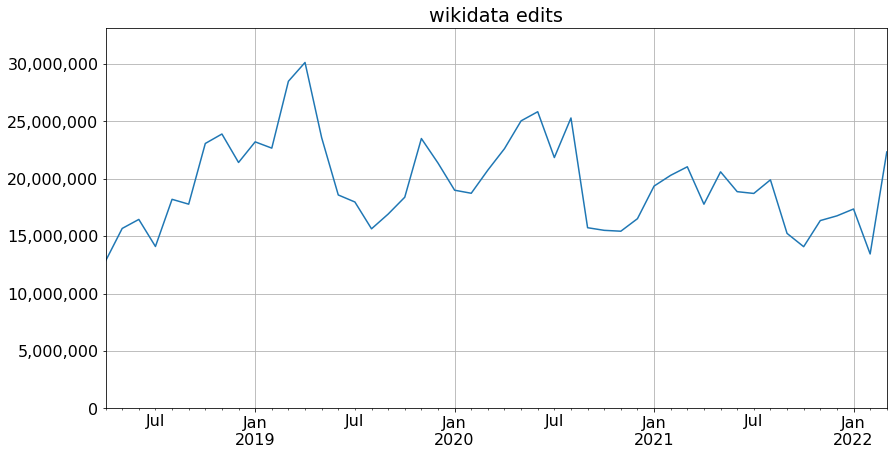

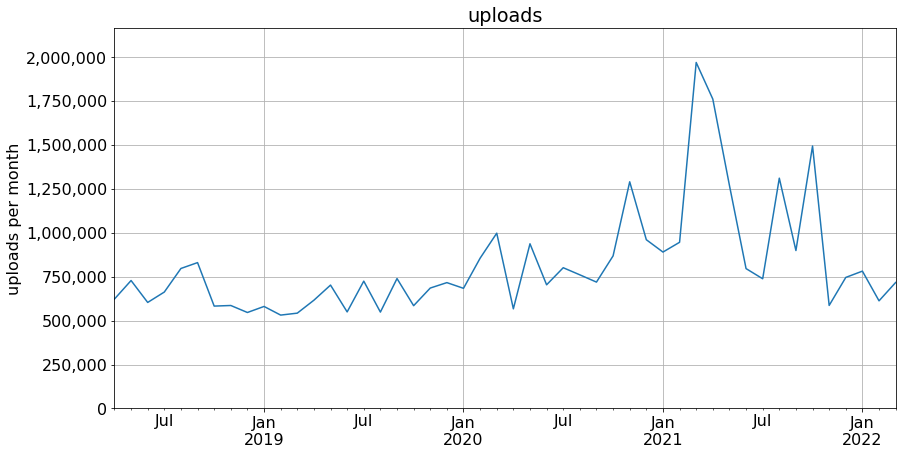

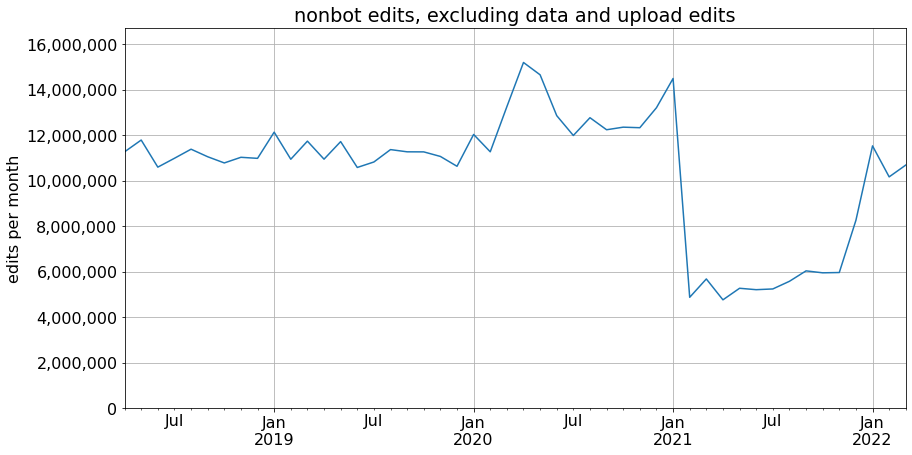

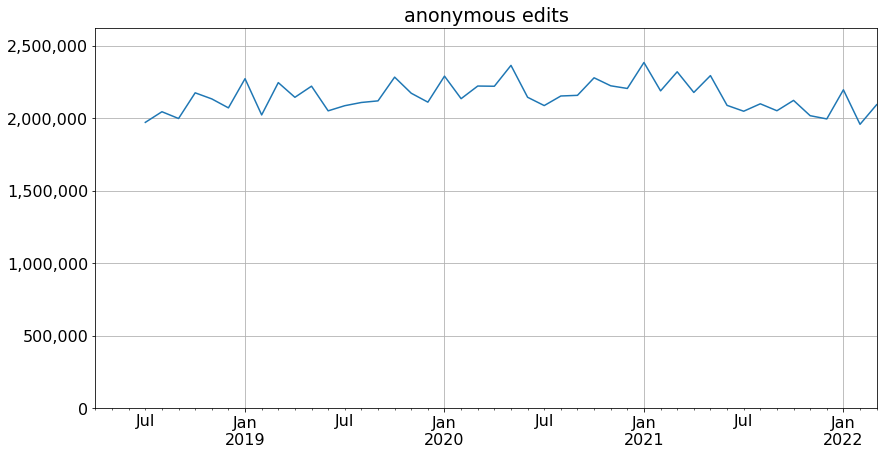

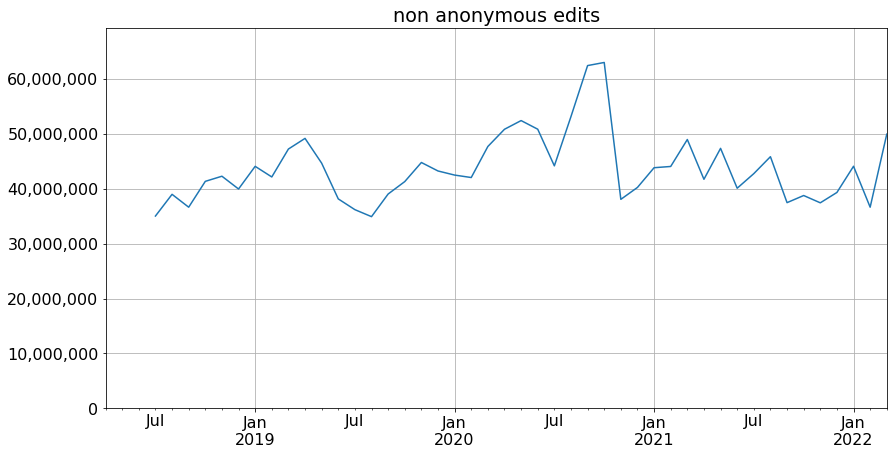

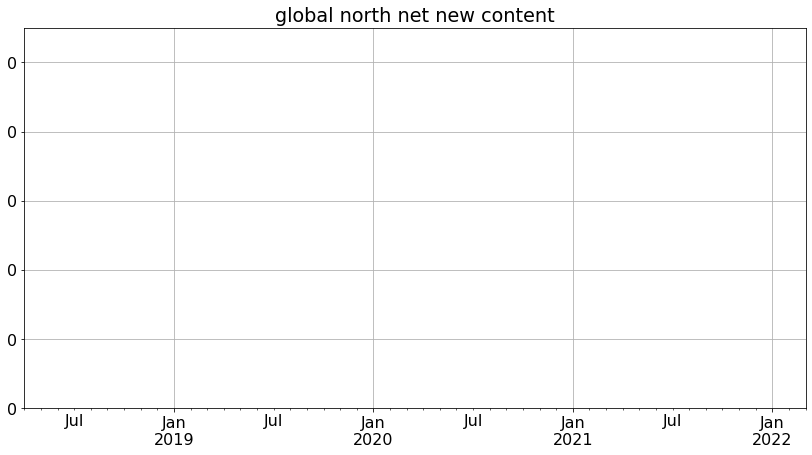

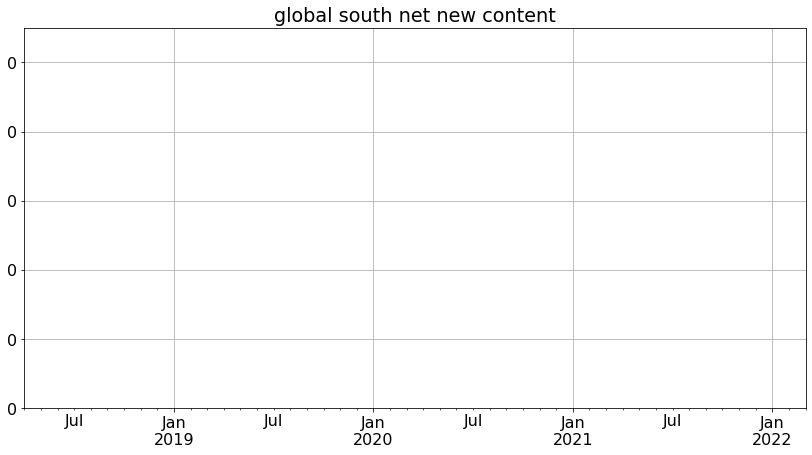

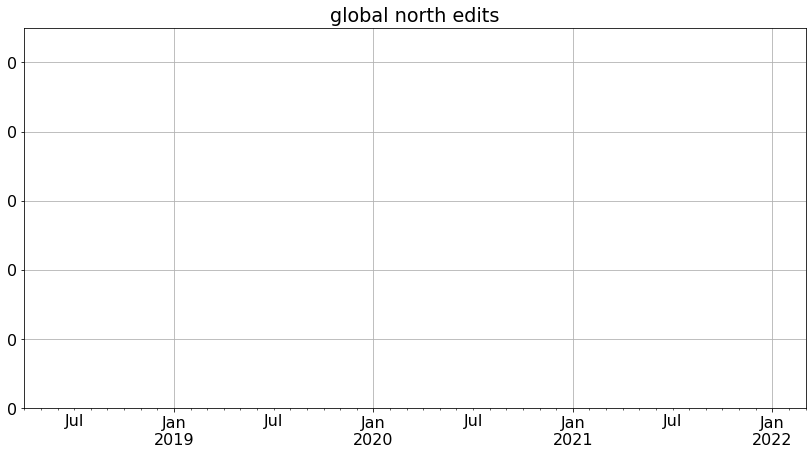

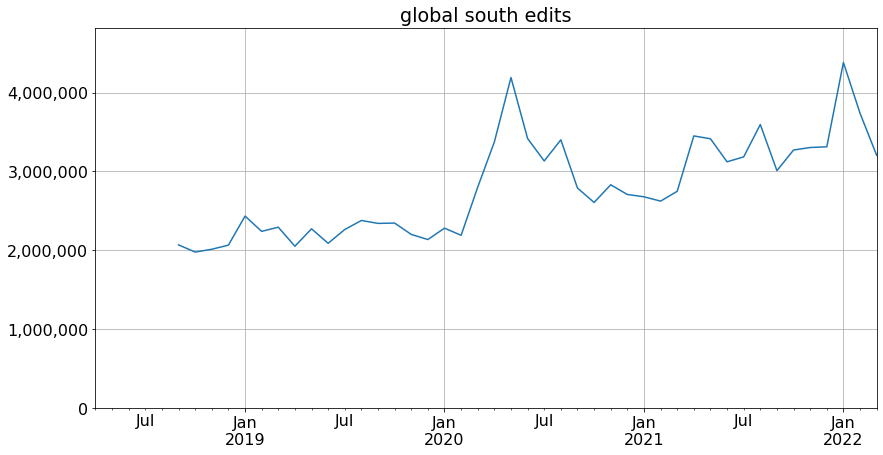

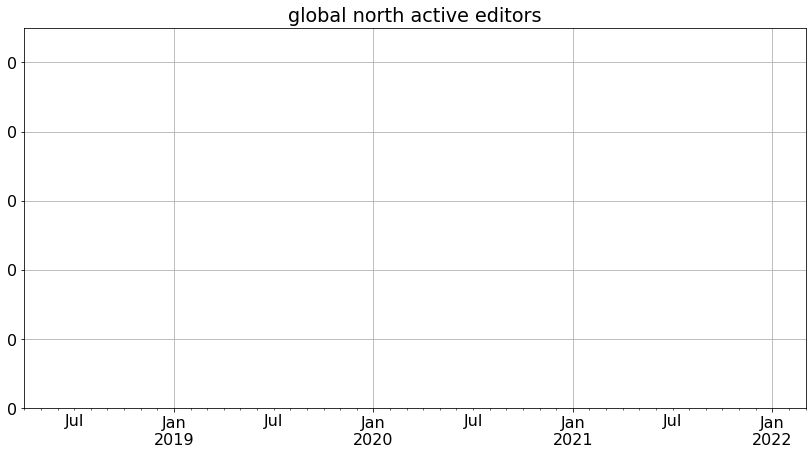

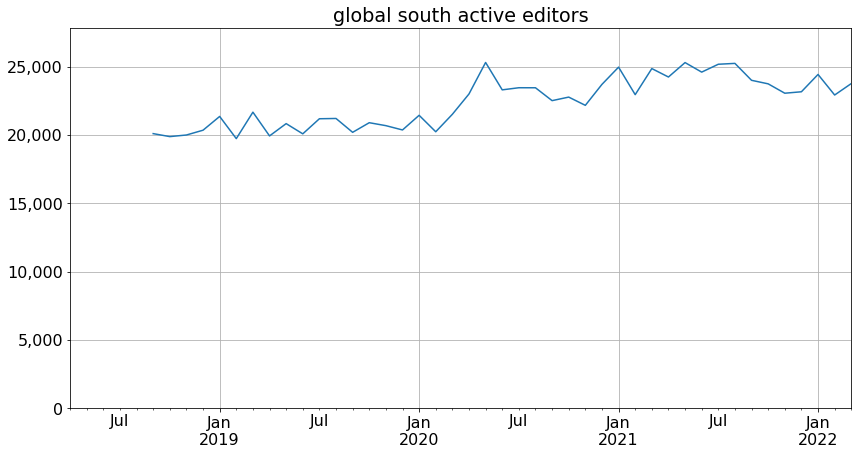

In [15]:
graph_cfg = {
    "active_editors": {
        "y_lab": "editors per month"
    },
    "content_pages": {
      #  "y_fmt": M_fmt,
        # removed M_Fmt from graph_cfg as a workaround for the error "M_str() takes 1 positional argument but 2 were given"
    },
    "Wikipedia_articles": {
       # "y_fmt": M_fmt,
    },
    "Wikidata_entities": {
       # "y_fmt": M_fmt,
    },
    "Commons_content_pages": {
       # "y_fmt": M_fmt,
    },
    "existing_active_editors": {
        "y_lab": "editors per month"
    },
    "new_active_editors": {
        "y_lab": "editors per month"
    },
    "second_month_active_editors": {
        "y_lab": "editors per month"
    },
    "total_edits": {
       # "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
   
    "other_nonbot_edits": {
       # "y_fmt": M_fmt,
        "y_lab": "edits per month",
        "title": "nonbot edits, excluding data and upload edits"
    },
    "new_editor_retention": {
        "y_fmt": pct_fmt,
        "y_lab": "% of new editors retained into 2nd month"
    },
    "revert_rate": {
        "y_fmt": pct_fmt,
        "y_lab": "% of non-bot edits reverted"
    },
    "uploads": {
        "y_lab": "uploads per month"
    },
    "data_edits": {
      #  "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "net_new_content_pages": {
       # "y_fmt": M_fmt,
        "title": "net new content (main namespace pages + files)"
    },
    "net_new_Wikipedia_articles": {
    },
    "net_new_Commons_content_pages": {
        "title": "net new files on all projects"
    },
    "net_new_Wikidata_entities": {
    },
    "global_north_net_new_content": {
    },
    "global_south_net_new_content": {
    },
     "global_north_edits": {
    },
    "global_south_edits": {
    },
     "global_north_active_editors": {
    },
    "global_south_active_editors": {
    }
   # "global_south_new_editor_retention": {
   #     "y_fmt": pct_fmt,
   #     "y_lab": "% of new editors retained into 2nd month"
   # },
   # "global_north_new_editor_retention": {
   #     "y_fmt": pct_fmt,
   #     "y_lab": "% of new editors retained into 2nd month"
   # }    
}


    
    

for name, col in metrics.reindex(report_order, axis=1).iteritems():
    cfg = graph_cfg.get(name, {})
    plt.figure()
    
    col[graph_start:graph_end].plot()

    plt.title(cfg.get("title", name.replace("_", " ")))
    plt.ylabel(cfg.get("y_lab", ""))
    plt.xlabel("")
    plt.gca().yaxis.set_major_formatter(cfg.get("y_fmt", comma_fmt))
    
    y_top = plt.ylim()[1] * 1.1
    plt.ylim(bottom=0, top=y_top)
    plt.show()
    plt.close()

# Update Editors Google Sheet

In [16]:
FILE = "metrics/metrics.tsv"
all_metrics = pd.read_csv(FILE, sep="\t")


DIV_FILE = "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(DIV_FILE, sep="\t")

In [17]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('key-metrics-343717-07427b76df93.json', scopes=scope)
gc = gspread.authorize(credentials)

In [18]:
all_metrics.iloc[-1,1:] = all_metrics.iloc[-1,1:].astype(float)
diversity_metrics.iloc[-1,1:] = diversity_metrics.iloc[-1,1:].astype(float)

In [19]:
@property
def sheet1(self):
    """Shortcut property for getting the first worksheet."""
    return self.get_worksheet(0)

In [20]:
wks1 = gc.open("editors").sheet1
new_metrics = all_metrics.iloc[-1,[0,1,2,11,12,13,14,15,16,17,18,19,20,21,22,23,24]].tolist()
wks1.append_row(new_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'metrics!A1:Q256',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'metrics!A257:Q257',
  'updatedRows': 1,
  'updatedColumns': 17,
  'updatedCells': 17}}

In [21]:
# To address NaN values that may cause errors when moving the values to sheets
#Replace all np.nan values with python's None
diversity_metrics = diversity_metrics.where(pd.notnull(diversity_metrics), None)

In [23]:
#You need to change the datatype to object
diversity_metrics = diversity_metrics.astype(object).where(diversity_metrics.notna(), None)

#didn't work:
#diversity_metrics.where(diversity_metrics.notnull(), None)

In [24]:
wks2 = gc.open("editors").get_worksheet(1)
div_metrics = diversity_metrics.iloc[-1].tolist()
wks2.append_row(div_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'diversity_global_market!A1:M51',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'diversity_global_market!A52:M52',
  'updatedRows': 1,
  'updatedColumns': 11,
  'updatedCells': 11}}

In [25]:
wks3 = gc.open("editors").get_worksheet(2)
mh_metrics = all_metrics.iloc[-1,[0,6,7,8,9]].tolist()
wks3.append_row(mh_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'diversity_mobile_heavy!A1:E254',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'diversity_mobile_heavy!A255:E255',
  'updatedRows': 1,
  'updatedColumns': 5,
  'updatedCells': 5}}

# Prep for Movement metric tables preparation - Editor sheet

In [26]:
mmtp_editor_report_order = [
     #Editors
    'active_editors',
    'new_active_editors',
    'returning_active_editors',
    'new_editor_retention',
]

In [27]:
#print the month to which this corresponds
print("Editors")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_editor_report_order)
    .fillna("—")
)

Editors
Month period: 2022-03


,value,yoy_change,4_yr_cagr
active_editors,"91,800",-8.5%,2.4%
new_active_editors,"17,800",-14.0%,2.8%
returning_active_editors,"74,000",-7.1%,2.4%
new_editor_retention,7.8%,4.8%,3.8%


In [28]:
#print the month to which this corresponds
print("Editors")
print("Month period:", prior_month.strftime("%Y-%m"))

(
    metrics_all
    .apply(calc_prev_month_rpt)
    .transpose()
    .reindex(mmtp_editor_report_order)
    .fillna("—")
)

Editors
Month period: 2022-02


,previous_M_value,PM_yoy_change,PM4_yr_cagr
active_editors,"88,300",-6.2%,0.7%
new_active_editors,"16,200",-13.5%,-1.8%
returning_active_editors,"72,100",-4.4%,1.3%
new_editor_retention,6.3%,-2.8%,-5.0%


# Prep for Movement metric tables preparation - Diversity sheet, Editors section

In [29]:
mmtp_diversity_editor_report_order = [
    #Editors
    'active_editors',
    #Diversity Editors
    'global_north_active_editors',       #— Established Markets
    'global_south_active_editors',       #— Emerging Markets
    'new_editor_retention',
    'global_north_new_editor_retention', #— Established Markets
    'global_south_new_editor_retention'  #— Emerging Markets
]

In [30]:
#print the month to which this corresponds
print("Editors - diversity")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_diversity_editor_report_order)
    .fillna("—")
)

Editors - diversity
Month period: 2022-03


,value,yoy_change,4_yr_cagr
active_editors,"91,800",-8.5%,2.4%
global_north_active_editors,"73,100",-8.1%,—
global_south_active_editors,"23,800",-4.4%,—
new_editor_retention,7.8%,4.8%,3.8%
global_north_new_editor_retention,—,—,—
global_south_new_editor_retention,—,—,—


In [31]:
#print the month to which this corresponds
print("Editors - diversity")
print("Month period:", prior_month.strftime("%Y-%m"))

(
    metrics_all
    .apply(calc_prev_month_rpt)
    .transpose()
    .reindex(mmtp_diversity_editor_report_order)
    .fillna("—")
)

Editors - diversity
Month period: 2022-02


,previous_M_value,PM_yoy_change,PM4_yr_cagr
active_editors,"88,300",-6.2%,0.7%
global_north_active_editors,"71,300",-5.7%,—
global_south_active_editors,"22,900",-0.1%,—
new_editor_retention,6.3%,-2.8%,-5.0%
global_north_new_editor_retention,—,—,—
global_south_new_editor_retention,—,—,—


# Prep for Movement metric tables preparation - Content sheet

In [32]:
mmtp_content_report_order = [
    # Content
    'content_pages', 
        'Wikipedia_articles',
        'Commons_content_pages', 
        'Wikidata_entities',
    'net_new_content_pages',
        'net_new_Wikipedia_articles',
        'net_new_Commons_content_pages',
        'net_new_Wikidata_entities',
    'revert_rate',
    'total_edits',
        'mobile_edits',
        'wikidata_edits',
        'uploads',
        'other_nonbot_edits',
]

In [33]:
#print the month to which this corresponds
print("Content")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_content_report_order)
    .fillna("—")
)

Content
Month period: 2022-03


,value,yoy_change,4_yr_cagr
content_pages,"299,000,000",8.3%,13.1%
Wikipedia_articles,"60,500,000",5.7%,6.0%
Commons_content_pages,"82,700,000",15.3%,15.4%
Wikidata_entities,"99,200,000",4.9%,20.6%
net_new_content_pages,"1,590,000",-49.3%,-7.2%
net_new_Wikipedia_articles,"208,000",-37.3%,4.8%
net_new_Commons_content_pages,"678,000",-64.8%,3.7%
net_new_Wikidata_entities,"357,000",-28.7%,-25.2%
revert_rate,4.7%,-15.6%,-17.6%
total_edits,"52,000,000",1.5%,10.8%


# Prep for Movement metric tables preparation - Diversity sheet, content section

In [34]:
mmtp_content_diversity_report_order = [
    # Content
    'content_pages',  #total content
    'net_new_content_pages',
    #Diversity Content
    'global_north_net_new_content',
    'global_south_net_new_content',
    'total_edits',
    'global_north_edits',
    'global_south_edits',
    'anonymous_edits',
]

In [35]:
#print the month to which this corresponds
print("Content")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_content_diversity_report_order)
    .fillna("—")
)

Content
Month period: 2022-03


,value,yoy_change,4_yr_cagr
content_pages,"299,000,000",8.3%,13.1%
net_new_content_pages,"1,590,000",-49.3%,-7.2%
global_north_net_new_content,"1,210,000",-50.2%,—
global_south_net_new_content,"292,000",28.7%,—
total_edits,"52,000,000",1.5%,10.8%
global_north_edits,"19,200,000",-33.3%,—
global_south_edits,"3,210,000",16.6%,—
anonymous_edits,"2,090,000",-9.8%,—


In [ ]:
#YoY Non-Wikidata net new content
#Year-over-year Growth = [(This Year – Last Year) / Last Year] X 100